## Modelling long-term and short-term memory using an attractor neural network with triple-well connections

In https://www.biorxiv.org/content/10.1101/2023.07.17.549266v1, the authors consider a model whose weights not only get updated at discrete learning episodes but also continuously evolve in time following the gradient of a double-well potential. Inspired by this idea, we consider a Hopfield model, whose weights evolve on a smooth potential with three distinct minima (and two local maxima) located at the specified values of the couplings (positive, negative and zero). This model is more realistic than the double-well model because, in the double-well model, every neuron eventually has finite connection strength to any other neuron even in the absence of stimulation (this is avoided by removing some of the connections artificially), whereas, in our model, the unstimulated neurons tend to get disconnected in some ranges of the parameters.

Furthermore, this simple system exhibits two types of memory: short-term memory (STM) and long-term memory (LTM). The STM occurs when the weights are within the attraction basin of w=0 (i.e. "within 0-well"), thus, in the absence of external stimulation and noise, such weights converge to zero after some deterministic time. If this is not the case, and the weights are within the non-zero wells, the memories of the unstimulated network may persist indefinitely, degrading only due to noise. Just like real memories, the memories of this model may transition from the STM to LTM, given enough stimulation.

The basic Python implementation of the model is below, and some project ideas can be found at the end of the notebook.

My email is o.senkevich@ulster.ac.uk

#### Importing the modules, preparing the data, initialising the weight matrix with zeros

In [1]:
# Download the dataset directory
!sudo apt-get install subversion
!svn export https://github.com/ISRC-CN3/Day-2-26-10/trunk/Projects/triple_well_HM/data


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2 subversion
0 upgraded, 6 newly installed, 0 to remove and 19 not upgraded.
Need to get 2,672 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libapr1 amd64 1.7.0-8ubuntu0.22.04.1 [108 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libaprutil1 amd64 1.6.1-5ubuntu4.22.04.2 [92.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libserf-1-1 amd64 1.3.9-10ubuntu2 [50.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libutf8proc2 amd64 2.7.0-3 [73.9 kB]
Get:5 http://archive.

In [23]:
import matplotlib
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['mathtext.fontset']='cm'
import numpy as np
import matplotlib.pyplot as plt
import random


# initialise weight matrix
dim = 25
num_neurons = dim**2

W = np.zeros([num_neurons, num_neurons])

# load data
train_images = np.genfromtxt('./data/25x25/2_5_combined', delimiter=',')

#### Visualising the images aranging the nodes in 2-D array

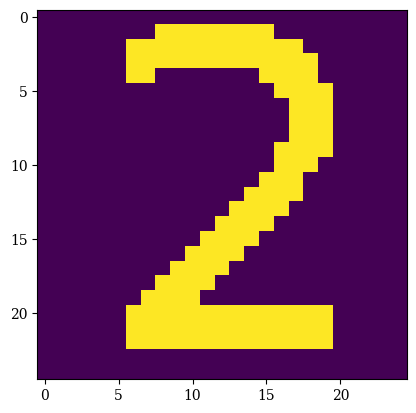

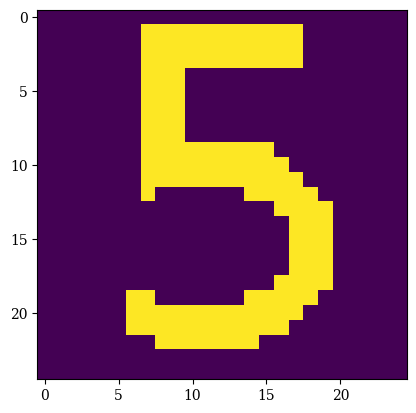

In [3]:
# train image 0
x = np.copy(train_images[0])
plt.imshow(np.reshape(x,(dim,dim)))
plt.show()
# train image 1
x = np.copy(train_images[1])
plt.imshow(np.reshape(x,(dim,dim)))
plt.show()

#### Defining the potential
- Setting the potential smoothly with the 6-th degree polynomial with only the even terms present. In this case, we can compute the position and the depths of all minima => we can set the parameters {a2, a4, a6} to match the desired shape of the potential.

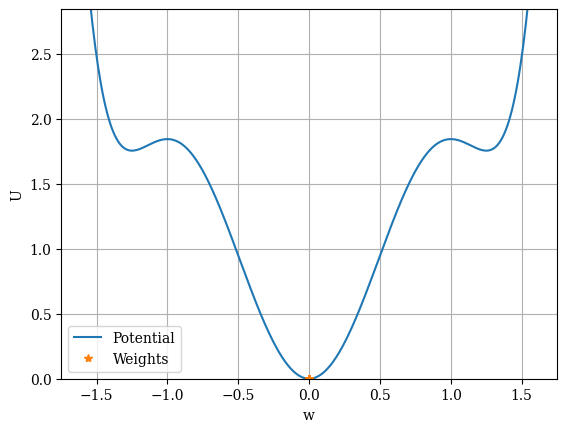

In [5]:
# Setting the parameters
# a2, a4, a6 = 5, -5, 1

Jm, Jp = 1, 1.25 # Distance to the outer minimum and maximum

a6 = 1
a2, a4 = 3*Jp**2*Jm**2*a6 , -3/2*(Jp**2+Jm**2)*a6

def U(J):
    return a2*J**2 + a4*J**4 + a6*J**6

def grad_U(J):
    return 2*a2*J + 4*a4*J**3 + 6*a6*J**5

def plot_potential_and_weights():
    J = np.arange(-Jp-.5, Jp+.5, .01)
    plt.plot(J, U(J), label="Potential")
    plt.plot(W.flatten(), U(W.flatten()), linestyle='none', marker='*', label="Weights")
    plt.xlim([-Jp-.5, Jp+.5])
    plt.ylim([min([U(Jp)-1, U(0)]), U(Jm)+1])
    plt.xlabel('w')
    plt.ylabel('U')
    plt.grid()
    plt.legend(loc=3)
    plt.show()


plot_potential_and_weights()

### Defining learning dynamics

In [10]:
Hebb_rate, relax_rate = .15, .05 # Hebbian learning and relaxation rates
noise_factor = .01 # Factor that regulates the magnitude of white noise in synapses

def present_pattern(pattern):
    ''' Receives a pattern and performs a step of Hebbian learning '''
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            W[i,j] += Hebb_rate*pattern[i]*pattern[j]
            W[j,i] = W[i,j]


def evolve(t_start, t_end, dt):
    '''
    Evolves the weights between the pattern presentations
    from t_start to t_end with time step dt
    '''
    for t in np.arange(t_start, t_end, dt):
        for i in range(num_neurons):
            for j in range(i+1, num_neurons):
                W[i,j] -= (relax_rate*grad_U(W[i,j]) + noise_factor*np.random.normal())*dt
                W[j,i] = W[i,j]

#### Defining presentation sequence

In [13]:
presentation_times = np.arange(0, 2.2, .2) # Times at which to present the patterns
presentation_sequence = []

for t in presentation_times:
  # presentation_sequence is the list of [presentation_time, index of the training pattern]
  presentation_sequence.append([t, np.random.choice([0,1])])


#### Simulating the dynamics

=================== At the beginning ======================


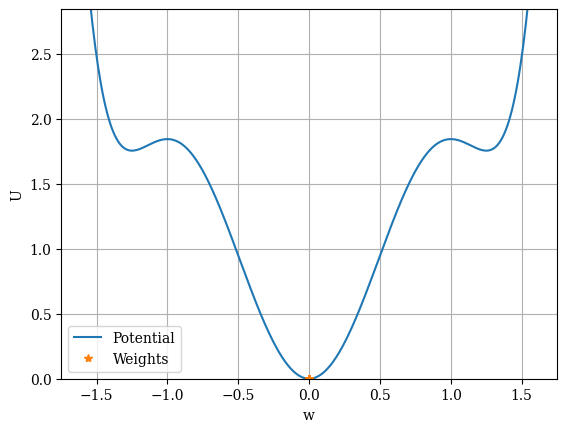

Presenting digit 5 at time point 0.0
======================= After Hebbian learning ======================


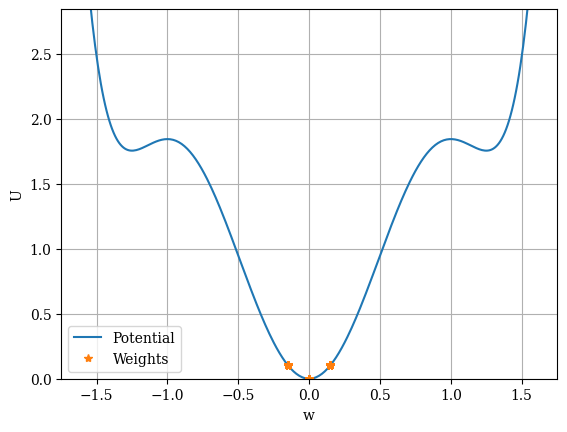

======================= After relaxing ===================


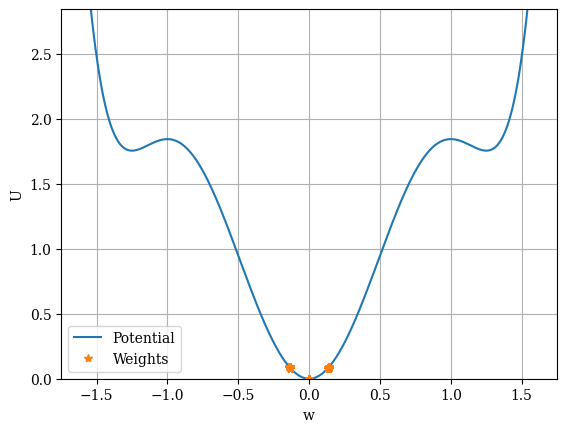

Presenting digit 2 at time point 0.2
======================= After Hebbian learning ======================


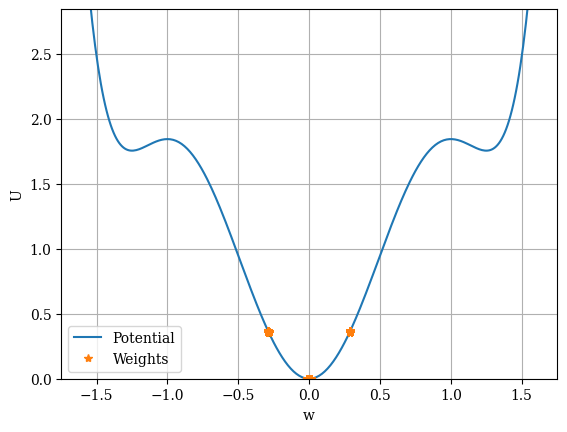

======================= After relaxing ===================


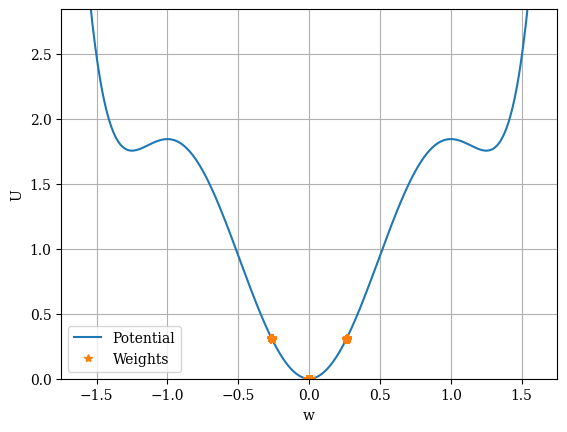

Presenting digit 2 at time point 0.4
======================= After Hebbian learning ======================


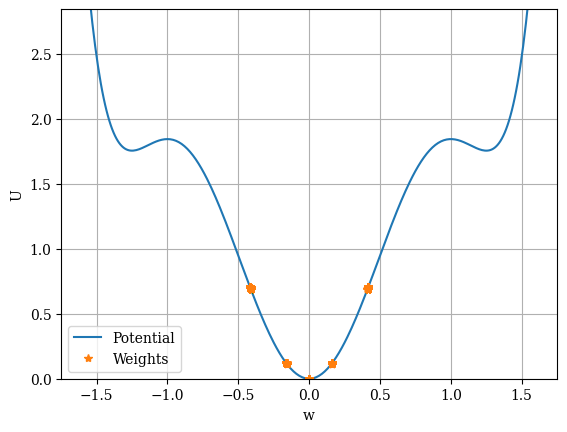

======================= After relaxing ===================


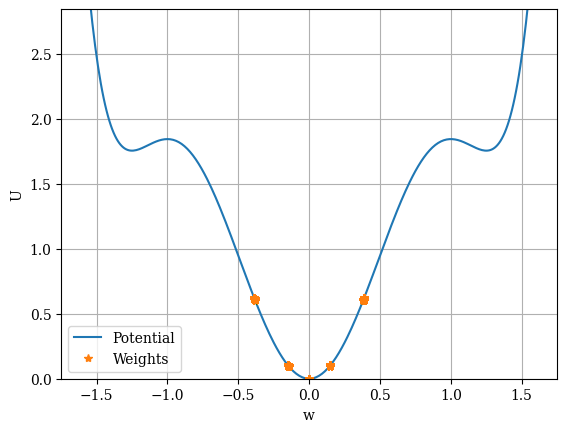

Presenting digit 2 at time point 0.6000000000000001
======================= After Hebbian learning ======================


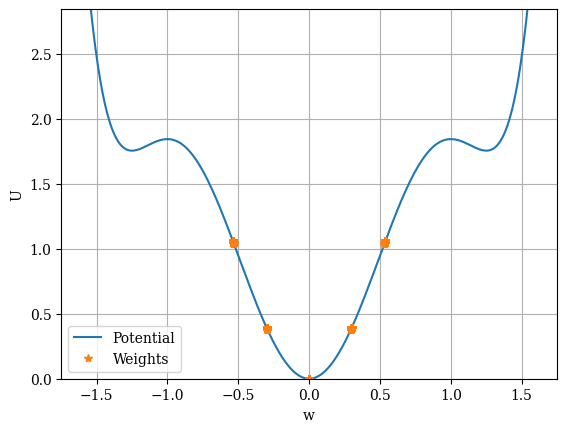

======================= After relaxing ===================


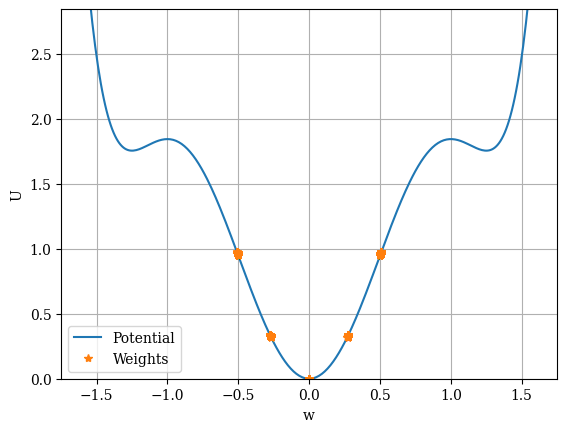

Presenting digit 5 at time point 0.8
======================= After Hebbian learning ======================


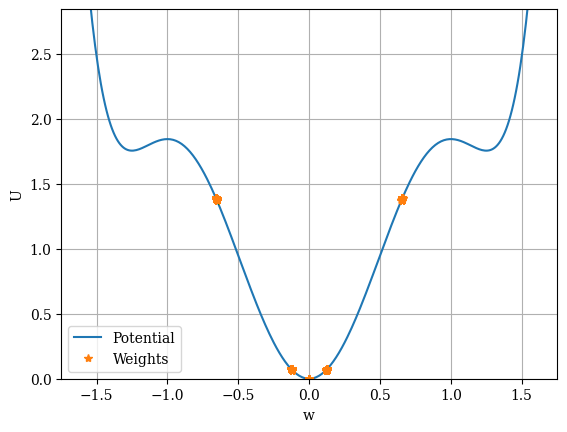

======================= After relaxing ===================


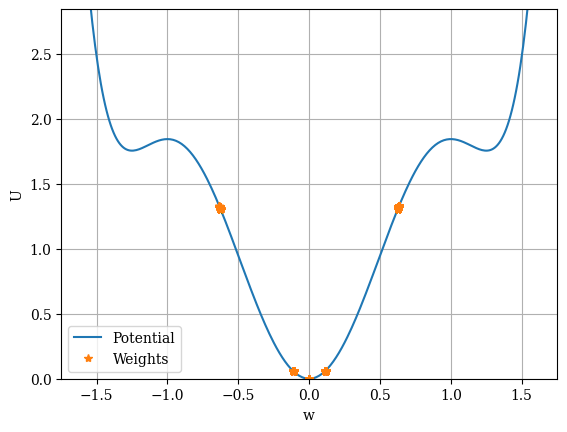

Presenting digit 5 at time point 1.0
======================= After Hebbian learning ======================


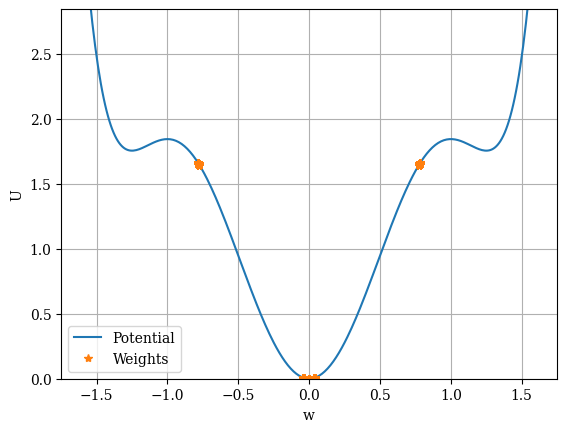

======================= After relaxing ===================


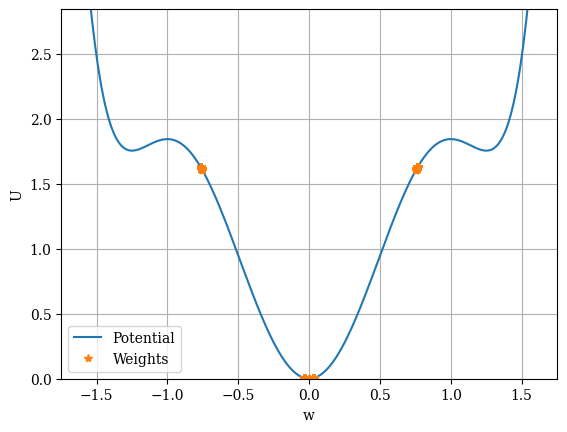

Presenting digit 2 at time point 1.2000000000000002
======================= After Hebbian learning ======================


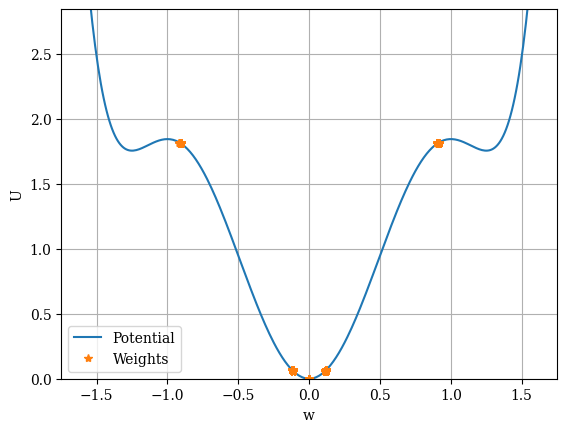

======================= After relaxing ===================


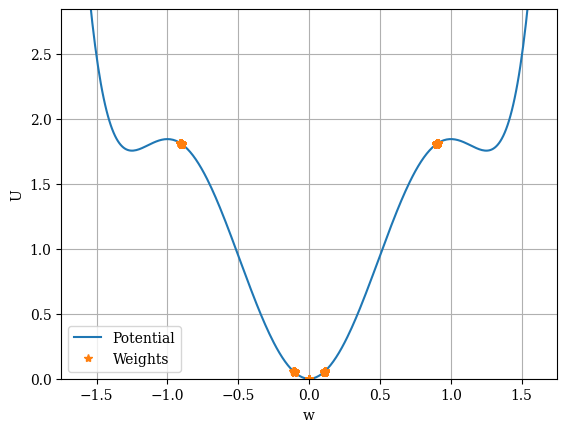

Presenting digit 2 at time point 1.4000000000000001
======================= After Hebbian learning ======================


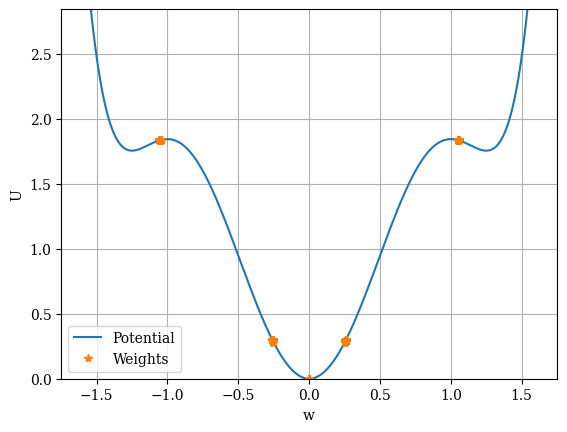

======================= After relaxing ===================


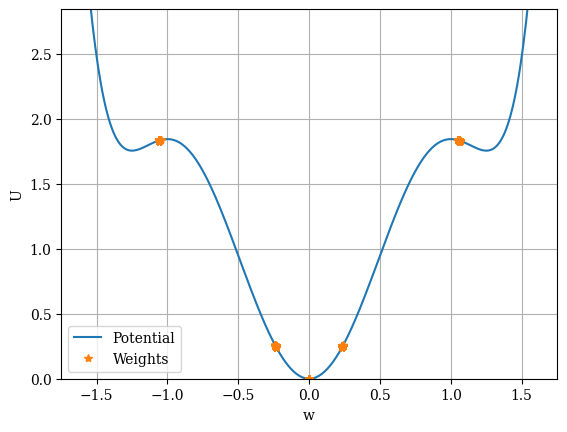

Presenting digit 5 at time point 1.6
======================= After Hebbian learning ======================


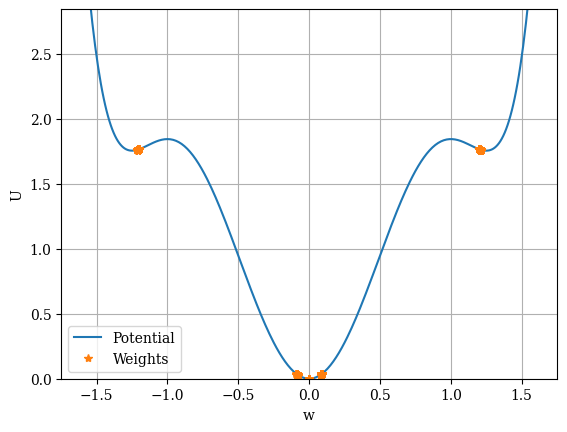

======================= After relaxing ===================


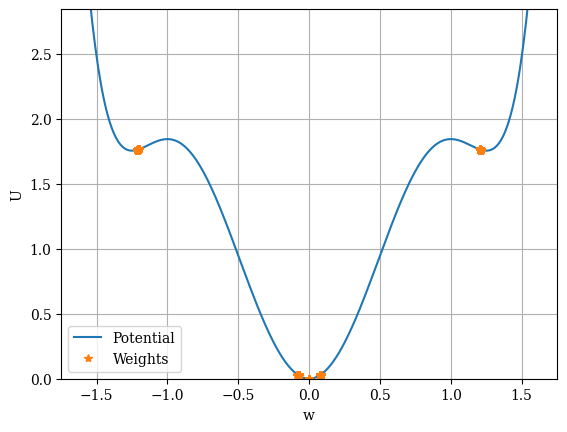

Presenting digit 2 at time point 1.8
======================= After Hebbian learning ======================


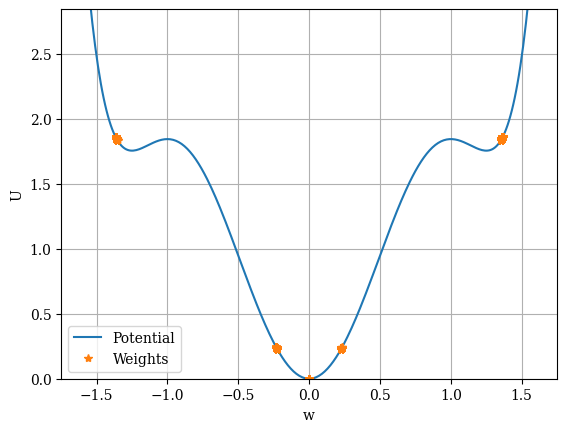

======================= After relaxing ===================


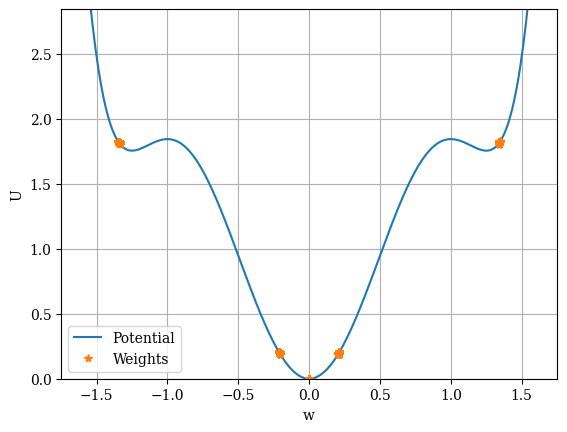

In [16]:
delay_time = 0.2
presentation_times = np.arange(0, 2.2, delay_time) # Times at which to present the patterns
presentation_sequence = []

for t in presentation_times:
  # presentation_sequence is the list of [presentation_time, index of the training pattern]
  presentation_sequence.append([t, np.random.choice([0,1])])

# Initialize weight matrix before learning
W = np.zeros([num_neurons, num_neurons])

print("=================== At the beginning ======================")
plot_potential_and_weights()

for le, le_next in zip(presentation_sequence[:-1], presentation_sequence[1:]) : # le stands for "learning episode"
  print(f"Presenting digit {5 if le[1] == 1 else 2} at time point {le[0]}")
  present_pattern(train_images[le[1]])
  print("======================= After Hebbian learning ======================")
  plot_potential_and_weights()
  evolve(t_start=le[0], t_end=le_next[0], dt=.01)
  print("======================= After relaxing ===================")
  plot_potential_and_weights()



#### Creating animation (optional)

Simulation time interval between the video frames:  0.010100000000000008
Simulation time =  0.01
current_frame: 1.0
Simulation time =  0.02
current_frame: 2.0
Simulation time =  0.03
current_frame: 3.0
Simulation time =  0.04
current_frame: 4.0
Simulation time =  0.05
current_frame: 5.0
Simulation time =  0.060000000000000005
current_frame: 6.0
Simulation time =  0.07
current_frame: 7.0
Simulation time =  0.08
current_frame: 8.0
Simulation time =  0.09
current_frame: 9.0
Simulation time =  0.09999999999999999
current_frame: 10.0
Simulation time =  0.10999999999999999
current_frame: 11.0
Simulation time =  0.11999999999999998
current_frame: 12.0
Simulation time =  0.12999999999999998
current_frame: 13.0
Simulation time =  0.13999999999999999
current_frame: 14.0
Simulation time =  0.15
current_frame: 15.0
Simulation time =  0.16
current_frame: 16.0
Simulation time =  0.17
current_frame: 17.0
Simulation time =  0.18000000000000002
current_frame: 18.0
Simulation time =  0.19000000000000003

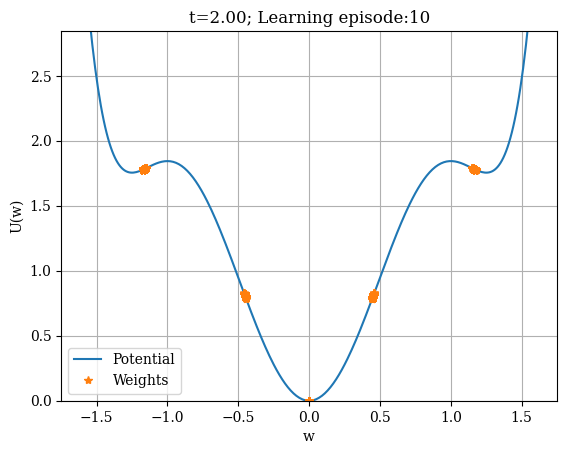

In [ ]:
import matplotlib.animation as manimation

W = np.zeros([num_neurons, num_neurons])

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title="Weights' dynamics", artist='CN3 Autumn School',
                comment='Dynamics of weights on a triple-well potential with Hebbian learning')
writer = FFMpegWriter(fps=7, metadata=metadata)

fig = plt.figure()

J = np.arange(-Jp-.5, Jp+.5, .01)
plt.plot(J, U(J), label="Potential")
weights_plot, = plt.plot([], [], linestyle='none', marker='*', label="Weights")
plt.xlim([-Jp-.5, Jp+.5])
plt.ylim([min([U(Jp)-1, U(0)]), U(Jm)+1])
plt.xlabel('w')
plt.ylabel('U(w)')
plt.grid()
plt.legend(loc=3)

Dts = (presentation_times[1:]-presentation_times[:-1])/20
Dt = max(Dts) * 1.01 # Time interval between the frames
print("Simulation time interval between the video frames: ", Dt)
sim_time, current_frame = 0, 0

with writer.saving(fig, f"weight_dynamics_{delay_time}.mp4", 200):
    for pn in range(len(presentation_times)-1):
        present_pattern(train_images[presentation_sequence[pn][1]])
        plt.title("t=" + "{:.2f}".format(sim_time) + "; Learning episode:" + str(pn+1))
        weights_plot.set_data(W.flatten(), U(W.flatten()))
        writer.grab_frame()
        for t in np.arange(presentation_times[pn], presentation_times[pn+1], Dts[pn]):
            evolve(t, t+Dts[pn], dt=.01)
            sim_time += Dts[pn]
            if sim_time // Dt > current_frame:
                weights_plot.set_data(W.flatten(), U(W.flatten()))
                plt.title("t=" + "{:.2f}".format(sim_time) + "; Learning episode:" + str(pn+1))
                writer.grab_frame()
                current_frame = sim_time//Dt
                print("current_frame:", current_frame)
            print("Simulation time = ", sim_time)#, end='\r')

##### The next cell will insert the video into the notebook

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f'weight_dynamics_{delay_time}.mp4','rb').read()
data_url = "data:weight_dynamics/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Defining the Hopfield update rule

In [7]:
# function for updating state asynchronously
def updateState():
    ind = random.choice(range(num_neurons))
    total_input = np.dot(W[ind,:],x)
    if total_input>=0:
        x[ind] = 1
    else:
        x[ind] = -1

def quality_of_recall(original_pattern, recalled_pattern):
    return np.mean(original_pattern == recalled_pattern)

def corrupt_pattern(pattern, flip_prob = .1):
    ''' Adds noise the pattern with the probability of flipping the node flip '''
    for i in range(num_neurons):
        if np.random.choice([True, False], p=(flip_prob, 1-flip_prob)):
            pattern[i] = -pattern[i]
    return pattern


### Recover corrupted image and compute recall

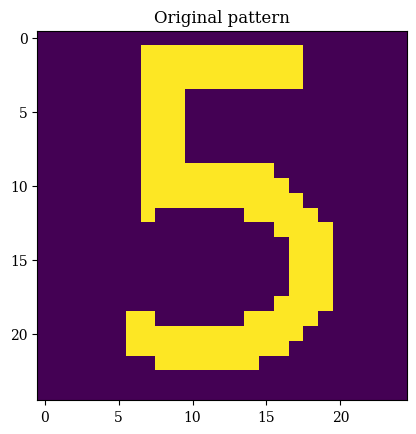

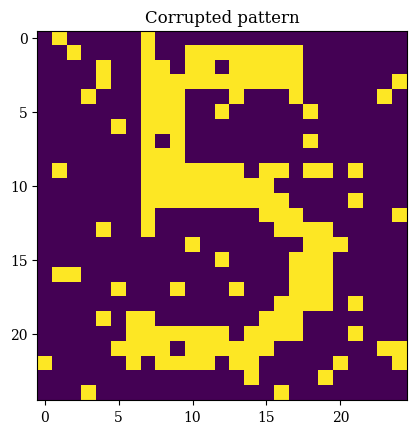

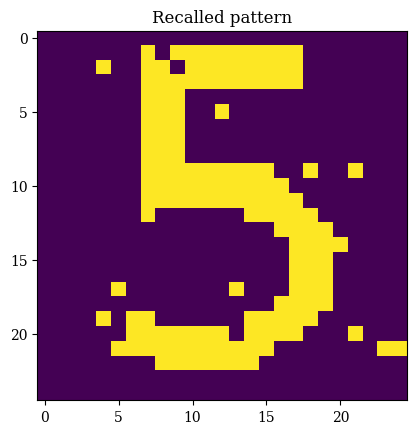

Quality of recall:  0.9744


In [19]:
original_pattern = train_images[1]

# Initialize weight matrix before learning
W = np.zeros([num_neurons, num_neurons])

num_repeat = 2
for repeat in range(num_repeat):
    # Train the network with the original pattern
    present_pattern(original_pattern)

    # Allow the weights to evolve over time
    evolve(0, 1, 0.1)


plt.imshow(np.copy(original_pattern).reshape(dim, dim))
plt.title("Original pattern")
plt.show()


x = corrupt_pattern(np.copy(original_pattern), flip_prob=.1)
plt.imshow(np.reshape(x,(dim,dim)))
plt.title("Corrupted pattern")
plt.show()

for i in range(1000):
    updateState()

recalled_pattern = x

plt.title("Recalled pattern")
plt.imshow(np.reshape(recalled_pattern,(dim,dim)))
plt.show()

print("Quality of recall: ", quality_of_recall(original_pattern, recalled_pattern))

## Project ideas

#### Project_1: Dependence of the memories on the delay between pattern presentations

It turns out that when the learning rate of the model is sufficiently low, the attractors of the network and their temporal evolution largely depend on the delay between the learning episodes (presentations of the patterns). Can you see why? For the given learning and relaxation rates, the shape of the potential and the noise factor, what is the time between image presentations after which the quality of the recovered patterns drops to 50% on average? How does this effect depend on the probability of a given neuron being active in a training pattern (aka sparsity or coding level of the input)?

#### Project_2: Influence of the long-term memory (LTM) on the short-term memory (STM)

Engagement of the long-term memory (LTM) should impair short-term memory (STM) performance due to the domination of the large LTM weights over the relatively small STM weights. Indeed, if the LTM is empty, the recovery of a single STM pattern is only limited by the weights' noise, which is assumed to be relatively small. However, if the LTM is not empty, the STM weights should be comparable with the LTM weights for the STM patterns to be recovered. This should dramatically increase the speed of forgetting, and the operation of the STM would only be possible under certain conditions. Find these conditions if they exist for dense and sparse patterns.

#### Project_3: Long-term memory decay caused by subthreshold learning and noise

If the depth of the outer wells is sufficiently small compared to the depth of the central well, presenting more patterns that do not make their way to the long-term memory (subthreshold learning) should still degrade the LTM memories. Can you see why? Can you verify that with simulations? Can this decay be somehow distinguished from the decay caused by noise?

#### Project_4: Stochastic resonance

The Hopfield model dynamics only depend on the ratios of weights; therefore, if the weights are noiseless, even the STM patterns can persist for a very long time (assuming the LTM is empty). Can you see why? However, it is unrealistic to assume noiseless connections, and adding some noise is expected to reduce the longevity of the memories. While this is true for the STM only (i.e., the palimpsest model), in our triple-well model, the noise may facilitate the transitions of the STM to LTM, implying nonuniform dependence of the memory longevity on the noise level.  Find the dependence of the memory lifetime on the noise level and see if this is indeed the case.

#### Project_5: Total memory capacity

Find out how many memories can be simultaneously loaded into the LTM of the network. Does the sparsity (codding level) of the input make any difference? Compare the results with that of the model with binary weights [REFERENCE].

#### Project_6: Asymmetric potential

Explore the model's behaviour when the potential becomes asymmetric, e.g. when a linear term is added to the potential.

#### Project_7: Heterogeneous connections

What will happen if the potential is not the same for all couplings, but has some variability insted?


### Average recall quality after series of learning and relaxation w

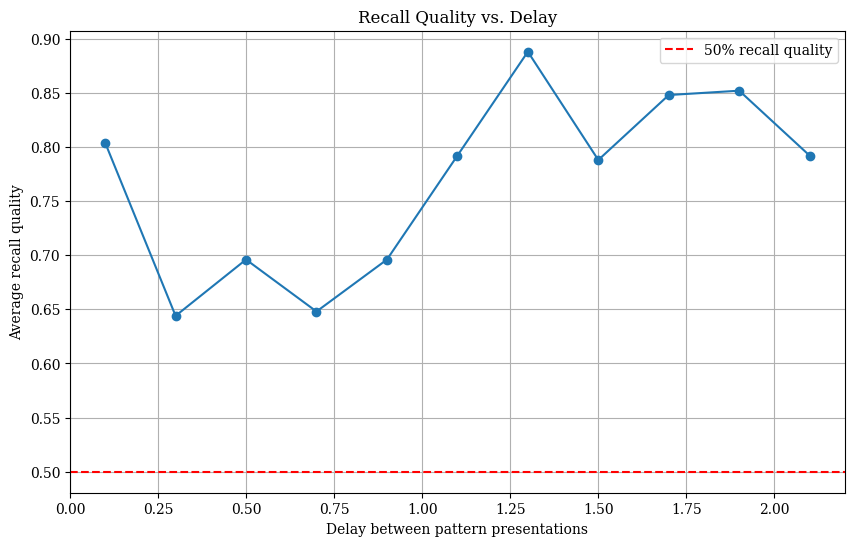

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Initialize weight matrix
dim = 5
num_neurons = dim**2
W = np.zeros([num_neurons, num_neurons])

# Load data
train_images = np.array([np.random.choice([1, -1], num_neurons) for _ in range(2)])

# Defining the potential
Jm, Jp = 1, 1.25
a6 = 1
a2, a4 = 3*Jp**2*Jm**2*a6, -3/2*(Jp**2+Jm**2)*a6

# Define potential function and its gradient
def U(J):
    return a2*J**2 + a4*J**4 + a6*J**6

def grad_U(J):
    return 2*a2*J + 4*a4*J**3 + 6*a6*J**5

# Defining learning dynamics
Hebb_rate, relax_rate = .15, .05
noise_factor = .01

# Define functions for Hebbian learning and weight evolution
def present_pattern(pattern):
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            W[i,j] += Hebb_rate*pattern[i]*pattern[j]
            W[j,i] = W[i,j]

def evolve(t_start, t_end, dt):
    for t in np.arange(t_start, t_end, dt):
        for i in range(num_neurons):
            for j in range(i+1, num_neurons):
                W[i,j] -= (relax_rate*grad_U(W[i,j]) + noise_factor*np.random.normal())*dt
                W[j,i] = W[i,j]

# Function for updating state asynchronously
def updateState(x):
    ind = random.choice(range(num_neurons))
    total_input = np.dot(W[ind,:], x)
    if total_input >= 0:
        x[ind] = 1
    else:
        x[ind] = -1

# Function for corrupting patterns with noise
def corrupt_pattern(pattern, flip_prob = .1):
    for i in range(num_neurons):
        if np.random.choice([True, False], p=(flip_prob, 1-flip_prob)):
            pattern[i] = -pattern[i]
    return pattern

# Function to simulate dynamics with varying delays
def simulate_dynamics_with_varying_delays(min_delay, max_delay, delay_step, num_trials=5):
    avg_qualities = []

    for delay in np.arange(min_delay, max_delay + delay_step, delay_step):
        presentation_times = np.arange(0, 2.2 + delay, delay)
        qualities = []

        for trial in range(num_trials):
            # Reset weight matrix and x
            W = np.zeros([num_neurons, num_neurons])

            for le, le_next in zip(presentation_times[:-1], presentation_times[1:]):
                # Train the network using both patterns
                for pattern in train_images:
                    present_pattern(pattern)
                    evolve(t_start=le, t_end=le_next, dt=.01)

            # Recall and calculate quality for each pattern
            recall_qualities = []
            for pattern in train_images:
                x = corrupt_pattern(np.copy(pattern), flip_prob=.4)
                for _ in range(100):
                    updateState(x)
                recall_qualities.append(quality_of_recall(pattern, x))

            # Average recall quality over all patterns
            qualities.append(np.mean(recall_qualities))

        avg_qualities.append(np.mean(qualities))

    return np.arange(min_delay, max_delay + delay_step, delay_step), avg_qualities

# Run the simulation with varying delays
delays, avg_qualities = simulate_dynamics_with_varying_delays(min_delay=0.1, max_delay=2, delay_step=0.2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(delays, avg_qualities, marker='o')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% recall quality')
plt.xlabel('Delay between pattern presentations')
plt.ylabel('Average recall quality')
plt.title('Recall Quality vs. Delay')
plt.legend()
plt.grid(True)
plt.show()


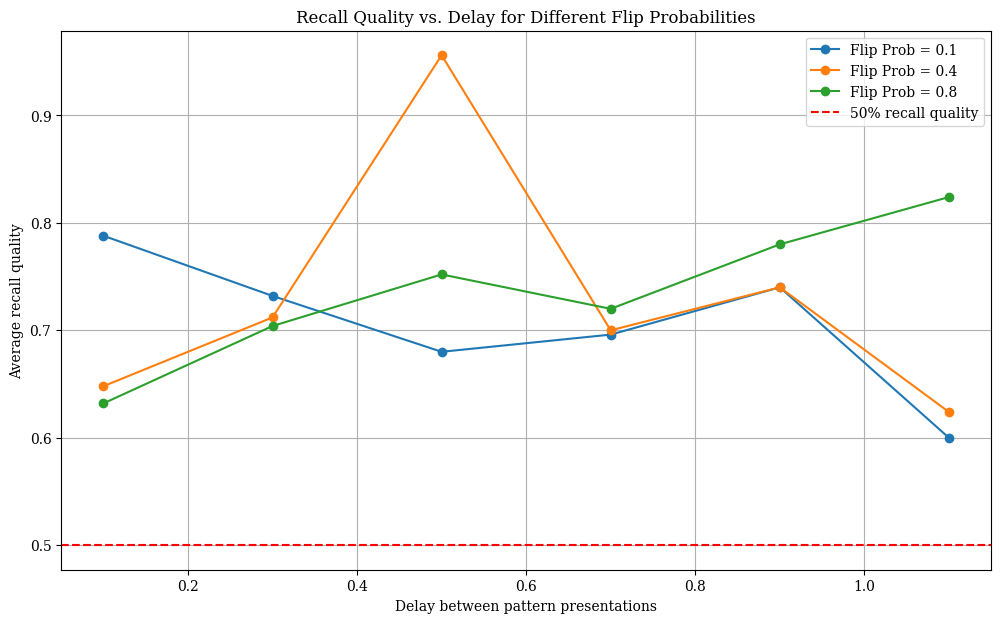

In [ ]:
# Function to simulate dynamics with varying delays for different flip probabilities
def simulate_for_flip_probs(flip_probs, min_delay, max_delay, delay_step, num_trials=5):
    results = {}

    for flip_prob in flip_probs:
        delays, avg_qualities = simulate_dynamics_with_varying_delays(min_delay, max_delay, delay_step, num_trials)
        results[flip_prob] = (delays, avg_qualities)

    return results

# List of flip probabilities to simulate for
flip_probs = [0.1, 0.4, 0.8]

# Run the simulation for different flip probabilities
results = simulate_for_flip_probs(flip_probs, min_delay=0.1, max_delay=1, delay_step=0.2)

# Plot the results for different flip probabilities
plt.figure(figsize=(12, 7))
for flip_prob, (delays, avg_qualities) in results.items():
    plt.plot(delays, avg_qualities, marker='o', label=f'Flip Prob = {flip_prob}')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% recall quality')
plt.xlabel('Delay between pattern presentations')
plt.ylabel('Average recall quality')
plt.title('Recall Quality vs. Delay for Different Flip Probabilities')
plt.legend()
plt.grid(True)
plt.show()

### Survey sparsity with small number of neurons and random pattern for recalling

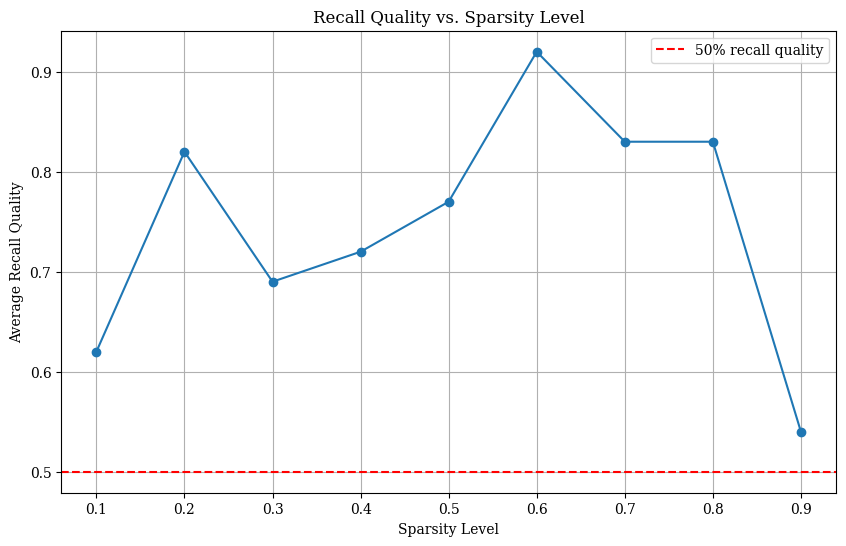

In [ ]:
def generate_sparse_pattern(sparsity, size=num_neurons):
    """Generate a pattern with a given sparsity."""
    num_active = int(sparsity * size)
    pattern = np.ones(size) * -1  # Start with all -1s (inactive)
    active_indices = np.random.choice(size, num_active, replace=False)
    pattern[active_indices] = 1  # Set randomly chosen indices to 1 (active)
    return pattern

def simulate_dynamics_with_varying_sparsity(sparsity_levels, delay, num_trials=5):
    """Simulate dynamics with patterns of varying sparsity levels."""
    avg_qualities = []

    for sparsity in sparsity_levels:
        qualities = []
        for trial in range(num_trials):
            # Generate a sparse pattern
            pattern = generate_sparse_pattern(sparsity)
            # Reset weight matrix and x
            W = np.zeros([num_neurons, num_neurons])

            for le, le_next in zip(presentation_times[:-1], presentation_times[1:]):
                # Train the network using both patterns
                for pattern in train_images:
                    present_pattern(pattern)
                    evolve(t_start=le, t_end=le_next, dt=.01)

            # Recall and calculate quality for each pattern
            recall_qualities = []
            for pattern in train_images:
                x = corrupt_pattern(np.copy(pattern), flip_prob=.4)
                for _ in range(1000):
                    updateState(x)
                recall_qualities.append(quality_of_recall(pattern, x))

            # Average recall quality over all patterns
            qualities.append(np.mean(recall_qualities))
        avg_qualities.append(np.mean(qualities))
    return avg_qualities

# Define a range of sparsity levels from 10% to 90%
sparsity_levels = np.linspace(0.1, 0.9, 9)

avg_qualities_sparsity = simulate_dynamics_with_varying_sparsity(sparsity_levels, delay=0.2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, avg_qualities_sparsity, marker='o')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% recall quality')
plt.xlabel('Sparsity Level')
plt.ylabel('Average Recall Quality')
plt.title('Recall Quality vs. Sparsity Level')
plt.legend()
plt.grid(True)
plt.show()


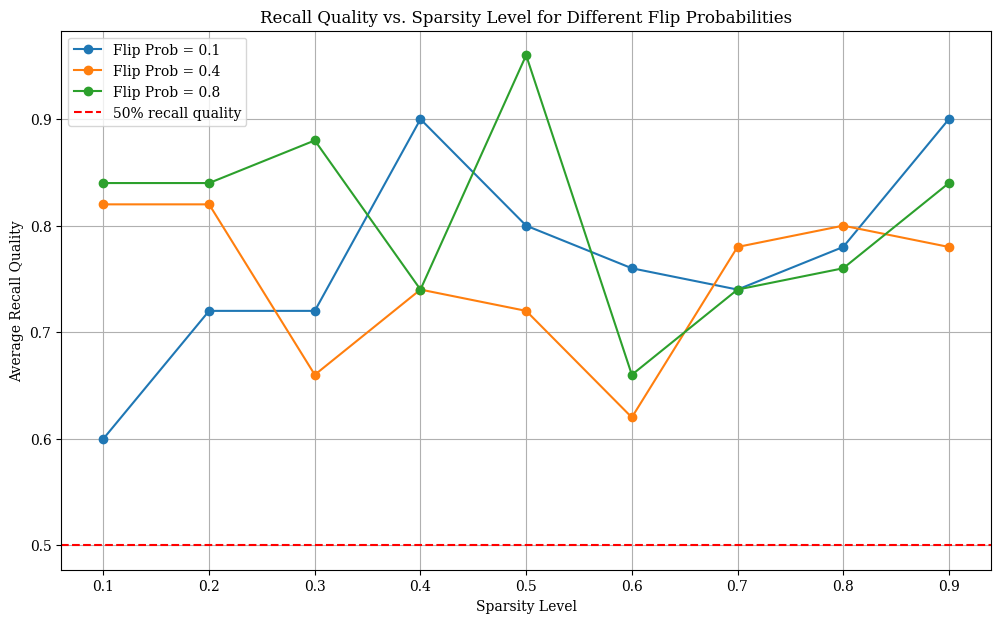

In [ ]:
def simulate_dynamics_with_varying_sparsity_for_flip_probs(sparsity_levels, flip_probs, delay, num_trials=5):
    """Simulate dynamics with patterns of varying sparsity levels for different flip probabilities."""
    results = {}

    for flip_prob in flip_probs:
        avg_qualities = simulate_dynamics_with_varying_sparsity(sparsity_levels, delay, num_trials=num_trials)
        results[flip_prob] = avg_qualities

    return results

# List of flip probabilities to simulate for
flip_probs_sparsity = [0.1, 0.4, 0.8]

# Run the simulation for different flip probabilities
results_sparsity = simulate_dynamics_with_varying_sparsity_for_flip_probs(sparsity_levels, flip_probs_sparsity, delay=0.2)

# Plot the results for different flip probabilities
plt.figure(figsize=(12, 7))
for flip_prob, avg_qualities in results_sparsity.items():
    plt.plot(sparsity_levels, avg_qualities, marker='o', label=f'Flip Prob = {flip_prob}')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% recall quality')
plt.xlabel('Sparsity Level')
plt.ylabel('Average Recall Quality')
plt.title('Recall Quality vs. Sparsity Level for Different Flip Probabilities')
plt.legend()
plt.grid(True)
plt.show()


### STM and LTM evolution with noise from original

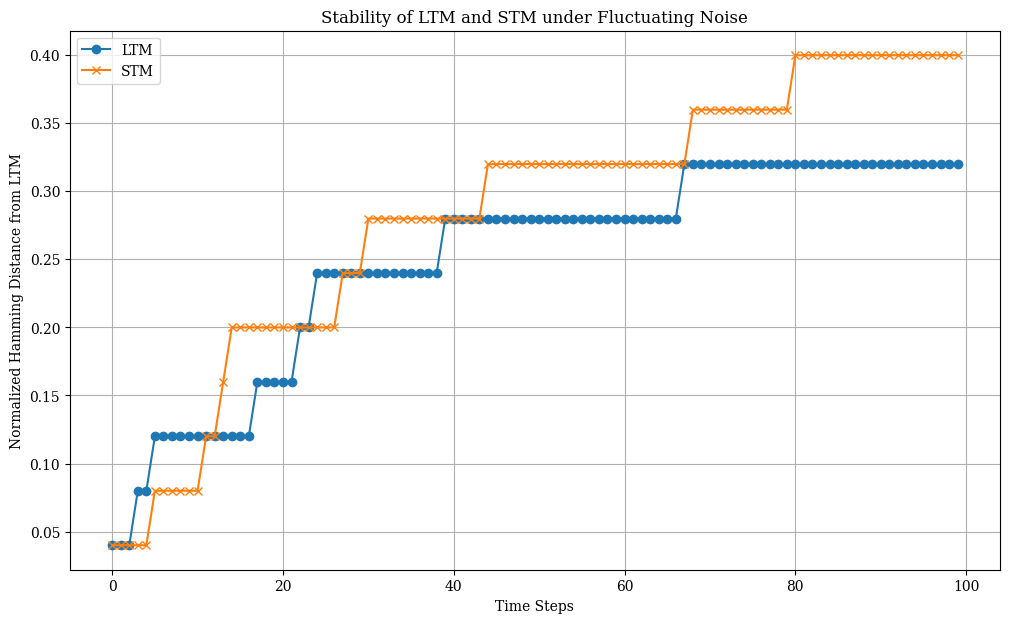

In [ ]:
def temporal_evolution_with_noise(pattern, noise_amplitude, timesteps=100):
    """Evolve a pattern over time with fluctuating noise and track its distance from the original."""
    distances = []
    x = np.copy(pattern).astype(float)
    for t in range(timesteps):
        # Introduce fluctuating noise
        noise = np.random.choice([1, -1], size=num_neurons, p=[0.5, 0.5]) * noise_amplitude
        x += noise
        x = np.sign(x)  # Ensure states are either +1 or -1
        # Evolve the pattern with one update step
        updateState(x)
        # Calculate distance from the original pattern
        distance = np.sum(np.abs(pattern - x) / 2) / num_neurons  # Normalized Hamming distance
        distances.append(distance)
    return distances

# Train the network with the first pattern (considered as LTM)
present_pattern(train_images[0])

# Create a corrupted version of the LTM as STM
stm_pattern = corrupt_pattern(train_images[0], flip_prob=0.3)

# Evolve both patterns with fluctuating noise and track their distances from the LTM
ltm_distances = temporal_evolution_with_noise(train_images[0], noise_amplitude=0.3)
stm_distances = temporal_evolution_with_noise(stm_pattern, noise_amplitude=0.3)

# Plot the distances over time
plt.figure(figsize=(12, 7))
plt.plot(ltm_distances, label='LTM', marker='o')
plt.plot(stm_distances, label='STM', marker='x')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Hamming Distance from LTM')
plt.title('Stability of LTM and STM under Fluctuating Noise')
plt.legend()
plt.grid(True)
plt.show()

### Recal quality vs delay after presentation

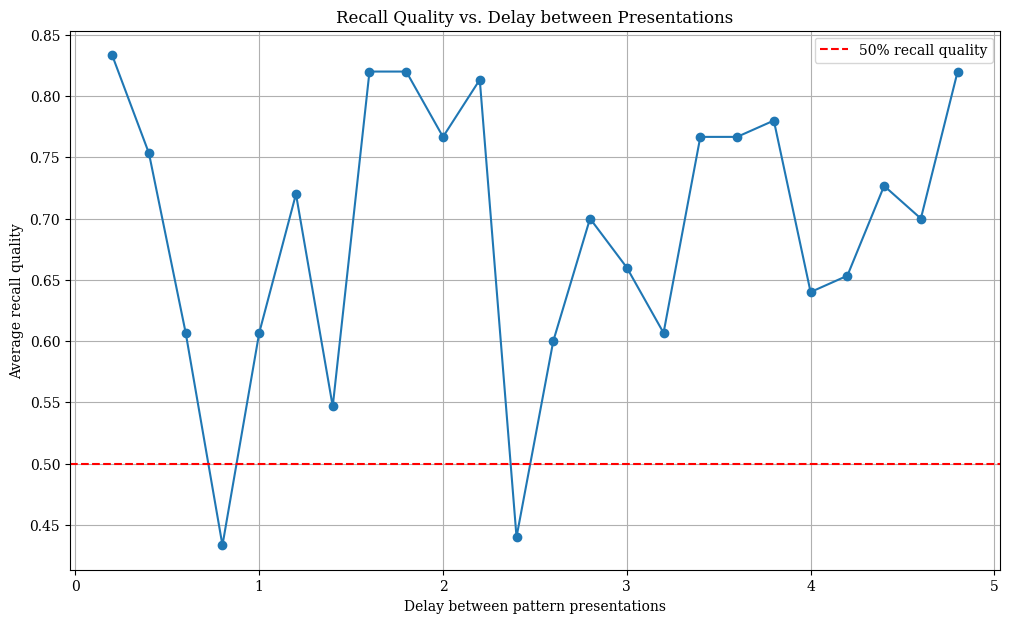

In [ ]:
def simulate_quality_for_delays(max_delay=5.0, delay_step=0.2, num_trials=3):
    """Simulate and return average recall quality for varying delays."""
    delays = []
    avg_qualities = []

    current_delay = delay_step
    while current_delay <= max_delay:
        presentation_times = np.arange(0, 2.2 + current_delay, current_delay)
        qualities = []

        for trial in range(num_trials):
            W = np.zeros([num_neurons, num_neurons])

            for le, le_next in zip(presentation_times[:-1], presentation_times[1:]):
                for pattern in train_images:
                    present_pattern(pattern)
                    evolve(t_start=le, t_end=le_next, dt=.01)

            recall_qualities = []
            for pattern in train_images:
                x = corrupt_pattern(np.copy(pattern), flip_prob=.4)
                for _ in range(100):
                    updateState(x)
                recall_qualities.append(quality_of_recall(pattern, x))

            qualities.append(np.mean(recall_qualities))

        delays.append(current_delay)
        avg_qualities.append(np.mean(qualities))
        current_delay += delay_step

    return delays, avg_qualities

# Get data for the plot
delays, avg_qualities = simulate_quality_for_delays()

# Plot the results
plt.figure(figsize=(12, 7))
plt.plot(delays, avg_qualities, marker='o')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% recall quality')
plt.xlabel('Delay between pattern presentations')
plt.ylabel('Average recall quality')
plt.title('Recall Quality vs. Delay between Presentations')
plt.legend()
plt.grid(True)
plt.show()


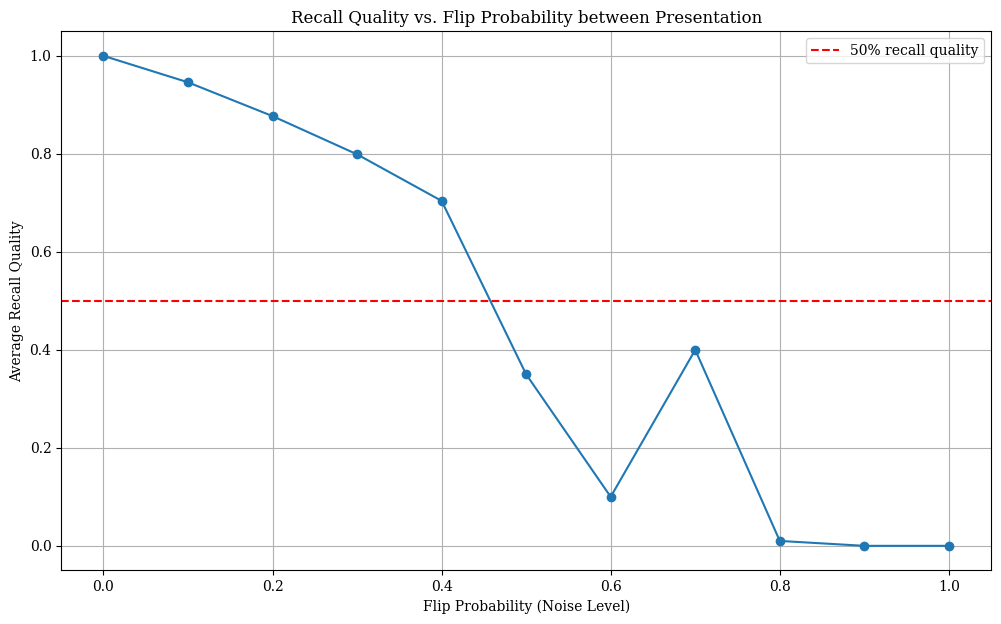

In [ ]:
def simulate_quality_for_flip_probs(flip_probs, max_delay=5.0, delay_step=0.5, num_trials=2):
    """Simulate and return average recall quality for varying flip probabilities."""
    avg_qualities_for_probs = []

    for flip_prob in flip_probs:
        current_delay = delay_step
        qualities = []

        while current_delay <= max_delay:
            presentation_times = np.arange(0, 2.2 + current_delay, current_delay)

            for trial in range(num_trials):
                W = np.zeros([num_neurons, num_neurons])

                for le, le_next in zip(presentation_times[:-1], presentation_times[1:]):
                    for pattern in train_images:
                        present_pattern(pattern)
                        evolve(t_start=le, t_end=le_next, dt=.01)

                recall_qualities = []
                for pattern in train_images:
                    x = corrupt_pattern(np.copy(pattern), flip_prob=flip_prob)
                    for _ in range(100):
                        updateState(x)
                    recall_qualities.append(quality_of_recall(pattern, x))

                qualities.append(np.mean(recall_qualities))

            # If average quality drops below 50% for the current delay, break
            if np.mean(qualities) <= 0.5:
                break

            current_delay += delay_step

        avg_qualities_for_probs.append(np.mean(qualities))

    return avg_qualities_for_probs

# Define a range of flip probabilities from 0% to 100%
flip_probs = np.linspace(0, 1, 11)

# Get data for the plot
avg_qualities_for_probs = simulate_quality_for_flip_probs(flip_probs)

# Plot the results for varying flip probabilities
plt.figure(figsize=(12, 7))
plt.plot(flip_probs, avg_qualities_for_probs, marker='o')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% recall quality')
plt.xlabel('Flip Probability (Noise Level)')
plt.ylabel('Average Recall Quality')
plt.title('Recall Quality vs. Flip Probability between Presentation')
plt.legend()
plt.grid(True)
plt.show()


### Recal quality vs delay after presentation for varying sparsity

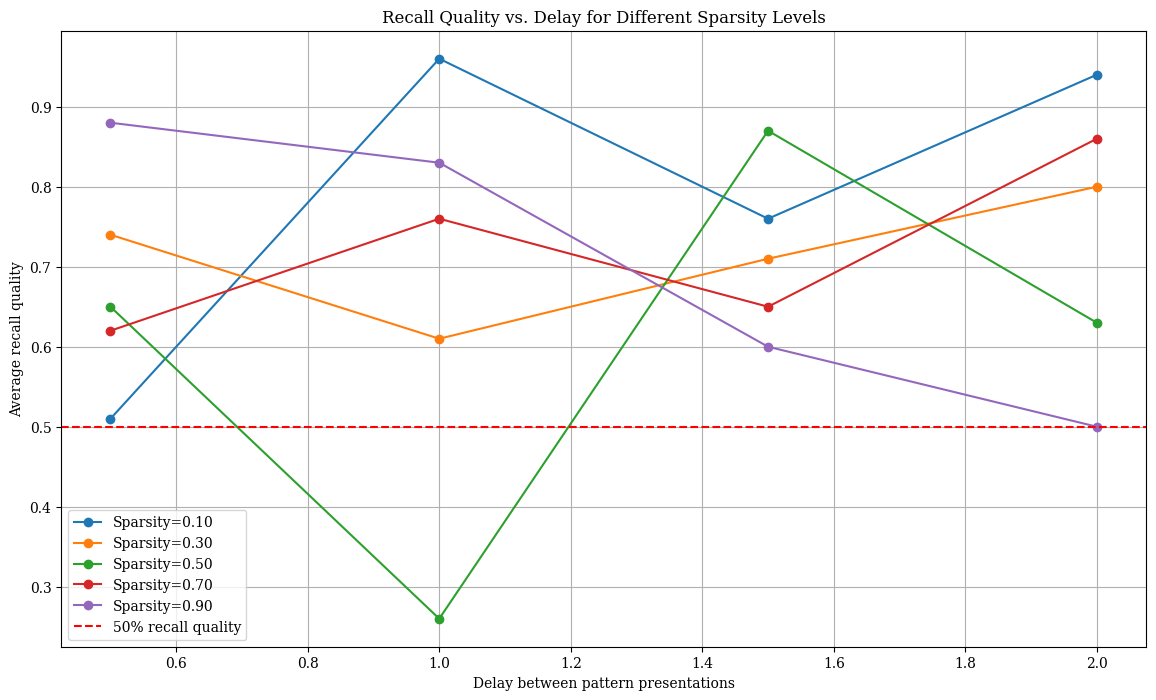

In [ ]:
def simulate_quality_for_sparsity_and_delays(sparsity_levels, max_delay=2.0, delay_step=0.5, num_trials=2):
    """Simulate and return average recall quality for varying sparsity levels and delays."""
    results = {}

    for sparsity in sparsity_levels:
        # Generate patterns with the current sparsity level
        sparse_train_images = np.array([generate_sparse_pattern(sparsity) for _ in range(2)])
        avg_qualities = []

        for delay in np.arange(delay_step, max_delay + delay_step, delay_step):
            presentation_times = np.arange(0, 2.2 + delay, delay)
            qualities = []

            for trial in range(num_trials):
                W = np.zeros([num_neurons, num_neurons])

                for le, le_next in zip(presentation_times[:-1], presentation_times[1:]):
                    for pattern in sparse_train_images:
                        present_pattern(pattern)
                        evolve(t_start=le, t_end=le_next, dt=.01)

                recall_qualities = []
                for pattern in sparse_train_images:
                    x = corrupt_pattern(np.copy(pattern), flip_prob=.4)
                    for _ in range(100):
                        updateState(x)
                    recall_qualities.append(quality_of_recall(pattern, x))

                qualities.append(np.mean(recall_qualities))

            avg_qualities.append(np.mean(qualities))

        results[sparsity] = avg_qualities

    return np.arange(delay_step, max_delay + delay_step, delay_step), results

# Define a range of sparsity levels from 10% to 90%
sparsity_levels = np.linspace(0.1, 0.9, 5)

# Get data for the plot
delays, results = simulate_quality_for_sparsity_and_delays(sparsity_levels)

# Plot the results for each sparsity level
plt.figure(figsize=(14, 8))
for sparsity, avg_qualities in results.items():
    plt.plot(delays, avg_qualities, marker='o', label=f'Sparsity={sparsity:.2f}')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% recall quality')
plt.xlabel('Delay between pattern presentations')
plt.ylabel('Average recall quality')
plt.title('Recall Quality vs. Delay for Different Sparsity Levels')
plt.legend()
plt.grid(True)
plt.show()


### Supthreshold learning LTM recall quality

In [ ]:
num_patterns = 2
W_ltm = np.zeros([num_neurons, num_neurons])
def generate_dense_pattern():
    """Generate a dense pattern."""
    return np.random.choice([1, -1], num_neurons)

def train_weights(patterns, W, learning_rate):
    """Train the weights using the given patterns and learning rate."""
    for pattern in patterns:
        for i in range(num_neurons):
            for j in range(i+1, num_neurons):
                W[i,j] += learning_rate * pattern[i] * pattern[j]
                W[j,i] = W[i,j]
    return W

# Store LTM Patterns
ltm_patterns = np.array([generate_dense_pattern() for _ in range(num_patterns)])
W_ltm = train_weights(ltm_patterns, W_ltm, Hebb_rate * 10)  # Deeply learned

# Store LTM Patterns (deeply learned)
ltm_patterns = np.array([generate_dense_pattern() for _ in range(num_patterns)])
W_ltm = train_weights(ltm_patterns, W_ltm, Hebb_rate * 10)  # Learn deeply

# Function to simulate subthreshold learning's effect on LTM recall quality
def subthreshold_learning_effect(num_new_patterns=10, subthreshold_rate=0.1):
    """Simulate the degradation of LTM due to subthreshold learning of new patterns."""
    recall_qualities = []

    # Current weight matrix
    W_current = W_ltm.copy()

    for _ in range(num_new_patterns):
        # Introduce a new pattern but learn it subthreshold
        new_pattern = generate_dense_pattern()
        W_current = train_weights([new_pattern], W_current, subthreshold_rate)

        # Measure recall quality of LTM patterns
        qualities = []
        for pattern in ltm_patterns:
            x = np.copy(pattern)
            for _ in range(100):
                updateState(x)
            qualities.append(quality_of_recall(pattern, x))

        recall_qualities.append(np.mean(qualities))

    return recall_qualities

# Get recall qualities after each subthreshold learning event
recall_qualities_subthreshold = subthreshold_learning_effect()

recall_qualities_subthreshold


[0.52, 0.48, 0.5, 0.54, 0.48, 0.54, 0.52, 0.54, 0.5, 0.54]

### Noise-induced decay

In [ ]:
def noise_induced_decay(noise_events=10, noise_intensity=0.1):
    """Simulate the degradation of LTM due to noise introduction."""
    recall_qualities = []

    # Current weight matrix
    W_current = W_ltm.copy()

    for _ in range(noise_events):
        # Introduce noise
        for i in range(num_neurons):
            for j in range(i+1, num_neurons):
                W_current[i,j] += noise_intensity * np.random.normal()
                W_current[j,i] = W_current[i,j]

        # Measure recall quality of LTM patterns
        qualities = []
        for pattern in ltm_patterns:
            x = np.copy(pattern)
            for _ in range(100):
                updateState(x)
            qualities.append(quality_of_recall(pattern, x))

        recall_qualities.append(np.mean(qualities))

    return recall_qualities

# Get recall qualities after each noise introduction event
recall_qualities_noise = noise_induced_decay()

recall_qualities_noise


[0.52, 0.54, 0.5, 0.54, 0.5, 0.54, 0.54, 0.5, 0.5, 0.52]

### LTM degradation due to subthreshold learning and noise

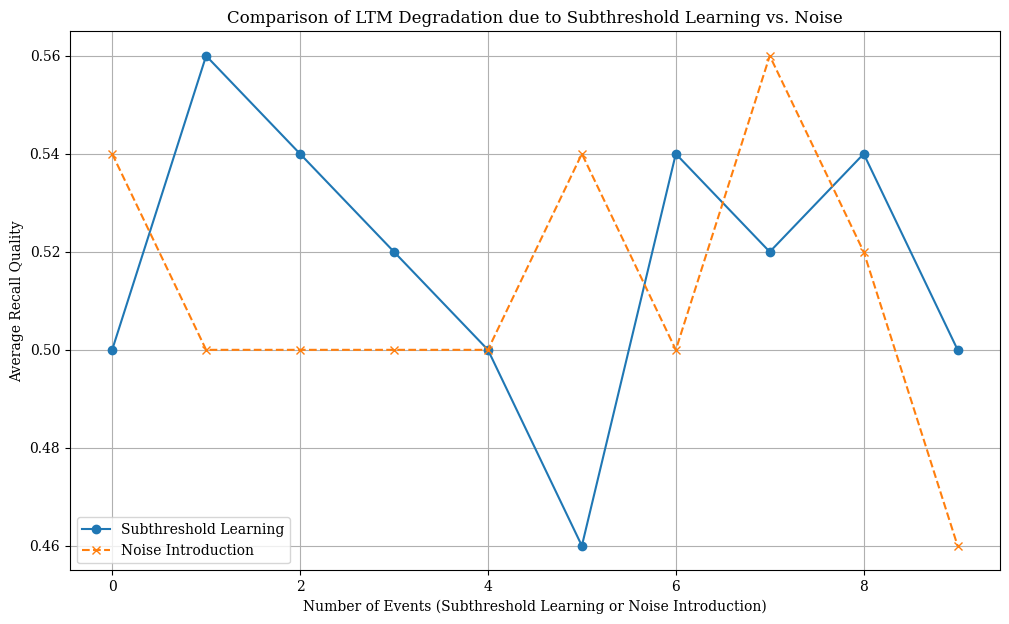

In [ ]:
# Simulation: Subthreshold Learning's Effect on LTM Recall Quality
def subthreshold_learning_effect(num_new_patterns=10, subthreshold_rate=0.1):
    W_current = W_ltm.copy()
    recall_qualities = []

    for _ in range(num_new_patterns):
        new_pattern = generate_dense_pattern()
        W_current = train_weights([new_pattern], W_current, subthreshold_rate)

        qualities = []
        for pattern in ltm_patterns:
            x = np.copy(pattern)
            for _ in range(100):
                updateState(x)
            qualities.append(quality_of_recall(pattern, x))

        recall_qualities.append(np.mean(qualities))

    return recall_qualities

recall_qualities_subthreshold = subthreshold_learning_effect()

# Simulation: Noise-Induced Decay's Effect on LTM Recall Quality
def noise_induced_decay(noise_events=10, noise_intensity=0.1):
    W_current = W_ltm.copy()
    recall_qualities = []

    for _ in range(noise_events):
        for i in range(num_neurons):
            for j in range(i+1, num_neurons):
                W_current[i,j] += noise_intensity * np.random.normal()
                W_current[j,i] = W_current[i,j]

        qualities = []
        for pattern in ltm_patterns:
            x = np.copy(pattern)
            for _ in range(100):
                updateState(x)
            qualities.append(quality_of_recall(pattern, x))

        recall_qualities.append(np.mean(qualities))

    return recall_qualities

recall_qualities_noise = noise_induced_decay()

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(recall_qualities_subthreshold, marker='o', label='Subthreshold Learning')
plt.plot(recall_qualities_noise, marker='x', linestyle='--', label='Noise Introduction')
plt.xlabel('Number of Events (Subthreshold Learning or Noise Introduction)')
plt.ylabel('Average Recall Quality')
plt.title('Comparison of LTM Degradation due to Subthreshold Learning vs. Noise')
plt.legend()
plt.grid(True)
plt.show()


### Memory longevity with noise levels

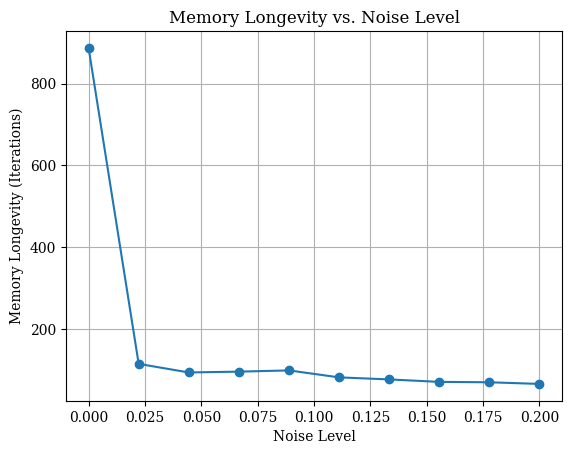

In [30]:
# Parameters
num_neurons = 25
Jm, Jp = 1, 1.25
a6 = 1
a2, a4 = 3*Jp**2*Jm**2*a6, -3/2*(Jp**2+Jm**2)*a6
Hebb_rate, relax_rate = .15, .05

# Define potential function and its gradient
def U(J):
    return a2*J**2 + a4*J**4 + a6*J**6

def grad_U(J):
    return 2*a2*J + 4*a4*J**3 + 6*a6*J**5

# Learning and weight evolution
def present_pattern(pattern, W):
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            W[i,j] += Hebb_rate*pattern[i]*pattern[j]
            W[j,i] = W[i,j]

def evolve(W, t_start, t_end, dt, noise_factor):
    for t in np.arange(t_start, t_end, dt):
        for i in range(num_neurons):
            for j in range(i+1, num_neurons):
                W[i,j] -= (relax_rate*grad_U(W[i,j]) + noise_factor*np.random.normal())*dt
                W[j,i] = W[i,j]



# Measure memory longevity with varying noise
def measure_memory_longevity(pattern, noise_level, max_iterations=1000):
    W = np.zeros([num_neurons, num_neurons])  # Initialize weights
    present_pattern(pattern, W)

    iterations = 0
    while iterations < max_iterations:
        evolve(W, 0, 0.1, 0.01, noise_level)
        test_pattern = corrupt_pattern(np.copy(pattern), flip_prob=0.1)
        for _ in range(20):
            updateState(test_pattern, W)
        recall_quality = quality_of_recall(pattern, test_pattern)
        if recall_quality < 0.8:
            break
        iterations += 1
    return iterations

noise_levels = np.linspace(0, 0.2, 10)
longevity_measurements = [measure_memory_longevity(train_images[1], noise) for noise in noise_levels]

plt.plot(noise_levels, longevity_measurements, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Memory Longevity (Iterations)')
plt.title('Memory Longevity vs. Noise Level')
plt.grid(True)
plt.show()


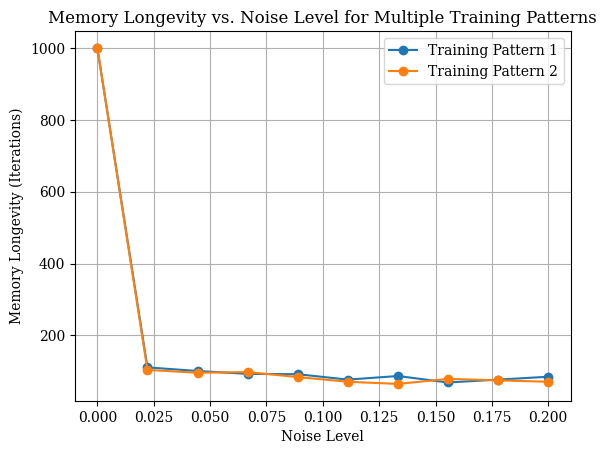

In [42]:
# Parameters
num_neurons = 25
Jm, Jp = 1, 1.25
a6 = 1
a2, a4 = 3*Jp**2*Jm**2*a6, -3/2*(Jp**2+Jm**2)*a6
Hebb_rate, relax_rate = .15, .05

# Define potential function and its gradient
def U(J):
    return a2*J**2 + a4*J**4 + a6*J**6

def grad_U(J):
    return 2*a2*J + 4*a4*J**3 + 6*a6*J**5

# Learning and weight evolution
def present_pattern(pattern, W):
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            W[i,j] += Hebb_rate*pattern[i]*pattern[j]
            W[j,i] = W[i,j]

def evolve(W, t_start, t_end, dt, noise_factor):
    for t in np.arange(t_start, t_end, dt):
        for i in range(num_neurons):
            for j in range(i+1, num_neurons):
                W[i,j] -= (relax_rate*grad_U(W[i,j]) + noise_factor*np.random.normal())*dt
                W[j,i] = W[i,j]



# Measure memory longevity with varying noise
def measure_memory_longevity(pattern, noise_level, max_iterations=1000):
    W = np.zeros([num_neurons, num_neurons])  # Initialize weights
    present_pattern(pattern, W)

    iterations = 0
    while iterations < max_iterations:
        evolve(W, 0, 0.1, 0.01, noise_level)
        test_pattern = corrupt_pattern(np.copy(pattern), flip_prob=0.1)
        for _ in range(20):
            updateState(test_pattern, W)
        recall_quality = quality_of_recall(pattern, test_pattern)
        if recall_quality < 0.8:
            break
        iterations += 1
    return iterations

noise_levels = np.linspace(0, 0.2, 10)


# Create a plot for each training pattern
for i, pattern in enumerate(train_images):
    pattern_longevity = [measure_memory_longevity(pattern, noise) for noise in noise_levels]
    plt.plot(noise_levels, pattern_longevity, marker='o', label=f'Training Pattern {i+1}')

plt.xlabel('Noise Level')
plt.ylabel('Memory Longevity (Iterations)')
plt.title('Memory Longevity vs. Noise Level for Multiple Training Patterns')
plt.grid(True)
plt.legend()
plt.show()